

##### Refernce  BOW IN WONDER LAND  https://www.kaggle.com/code/bowinlavenderfield/happy-whale-dolphin-type-classification/notebook   4 votes
##### Refernce  SIRISAP                https://www.kaggle.com/code/sirisap/whales-dolphins-vision-transformer                            1 votes



In [1]:
!nvidia-smi

Wed Apr 26 16:23:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   38C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import cv2

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


import torchvision
from torchvision import transforms
import torchvision.models as models
from PIL import Image

## Utils
import joblib
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:

CONFIG = {
    'EPOCHS': 50,
    'img_size': 224,
    'seed': 22,
    'train_batch_size': 80,
    'test_batch_size': 80,
    'num_classes': 2,
    'device' : "mps" if getattr(torch,'has_mps',False) else "cuda" if torch.cuda.is_available() else "cpu"
}

CONFIG

{'EPOCHS': 50,
 'img_size': 224,
 'seed': 22,
 'train_batch_size': 80,
 'test_batch_size': 80,
 'num_classes': 2,
 'device': 'cuda'}

# Index

In [4]:
Train_Base_path = "./alien_vs_predator_data/train/"

timage=[]
tlabels=[]
for folder in os.listdir(Train_Base_path):
    if os.path.isdir(Train_Base_path+folder):
        for file in os.listdir(Train_Base_path+folder):
            if file.endswith('jpg') :
                timage.append(Train_Base_path+folder+"/"+file)
                tlabels.append(folder)

print("number of train images",len(timage))

number of train images 694


In [5]:

Validate_Base_path = "./alien_vs_predator_data/validation/"

vimage=[]
vlabels=[]
for folder in os.listdir(Validate_Base_path):
    if os.path.isdir(Validate_Base_path+folder):
        for file in os.listdir(Validate_Base_path+folder):
            if file.endswith('jpg') :
                vimage.append(Validate_Base_path+folder+"/"+file)
                vlabels.append(folder)

print("number of validate images",len(vimage))

number of validate images 200


# Lablled data Training

In [6]:
df_train_data = {'Images':timage, 'labels':tlabels} 
df_train_data = pd.DataFrame(df_train_data) 
df_train_data.sample(10)


,Images,labels
589,./alien_vs_predator_data/train/predator/187.jpg,predator
290,./alien_vs_predator_data/train/alien/88.jpg,alien
629,./alien_vs_predator_data/train/predator/277.jpg,predator
356,./alien_vs_predator_data/train/predator/37.jpg,predator
369,./alien_vs_predator_data/train/predator/251.jpg,predator
153,./alien_vs_predator_data/train/alien/120.jpg,alien
568,./alien_vs_predator_data/train/predator/238.jpg,predator
56,./alien_vs_predator_data/train/alien/272.jpg,alien
504,./alien_vs_predator_data/train/predator/46.jpg,predator
545,./alien_vs_predator_data/train/predator/22.jpg,predator


In [7]:
df_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694 entries, 0 to 693
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Images  694 non-null    object
 1   labels  694 non-null    object
dtypes: object(2)
memory usage: 11.0+ KB


In [8]:
df_train_data = {'Images':timage, 'labels':tlabels} 
df_train_data = pd.DataFrame(df_train_data) 

lb = LabelEncoder()
df_train_data['encoded_labels'] = lb.fit_transform(df_train_data['labels'])
df_train_data.sample(10)

,Images,labels,encoded_labels
251,./alien_vs_predator_data/train/alien/9.jpg,alien,0
161,./alien_vs_predator_data/train/alien/274.jpg,alien,0
257,./alien_vs_predator_data/train/alien/131.jpg,alien,0
416,./alien_vs_predator_data/train/predator/322.jpg,predator,1
313,./alien_vs_predator_data/train/alien/281.jpg,alien,0
681,./alien_vs_predator_data/train/predator/5.jpg,predator,1
36,./alien_vs_predator_data/train/alien/19.jpg,alien,0
79,./alien_vs_predator_data/train/alien/151.jpg,alien,0
358,./alien_vs_predator_data/train/predator/95.jpg,predator,1
307,./alien_vs_predator_data/train/alien/309.jpg,alien,0


# Lablled data Validation

In [9]:
df_val_data = {'Images':vimage, 'labels':vlabels} 
df_val_data = pd.DataFrame(df_val_data) 

lb = LabelEncoder()
df_val_data['encoded_labels'] = lb.fit_transform(df_val_data['labels'])

df_val_data.sample(10)


,Images,labels,encoded_labels
64,./alien_vs_predator_data/validation/alien/71.jpg,alien,0
51,./alien_vs_predator_data/validation/alien/15.jpg,alien,0
134,./alien_vs_predator_data/validation/predator/5...,predator,1
98,./alien_vs_predator_data/validation/alien/57.jpg,alien,0
88,./alien_vs_predator_data/validation/alien/77.jpg,alien,0
76,./alien_vs_predator_data/validation/alien/18.jpg,alien,0
42,./alien_vs_predator_data/validation/alien/40.jpg,alien,0
132,./alien_vs_predator_data/validation/predator/3...,predator,1
102,./alien_vs_predator_data/validation/predator/3...,predator,1
139,./alien_vs_predator_data/validation/predator/6...,predator,1


# Dataset and Dataloader

In [10]:
class Dataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['Images'].values
        self.labels = df['encoded_labels'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = np.array(Image.open(img_path).convert("RGB"))
        label = self.labels[index]
        
        
        if self.transforms:
            img = self.transforms(img)
          
            
        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }



data_transforms = {
    'train':
    transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((CONFIG['img_size'],CONFIG['img_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

       
       
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((CONFIG['img_size'],CONFIG['img_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

       
     
    ]),
}

In [11]:
train_dataset = Dataset(df_train_data, transforms=data_transforms['train'])
train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], num_workers=0, shuffle=True, drop_last=True)

val_dataset = Dataset(df_val_data, transforms=data_transforms['validation'])
val_loader = DataLoader(val_dataset, batch_size= CONFIG["test_batch_size"], num_workers=2, shuffle=False, drop_last= False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


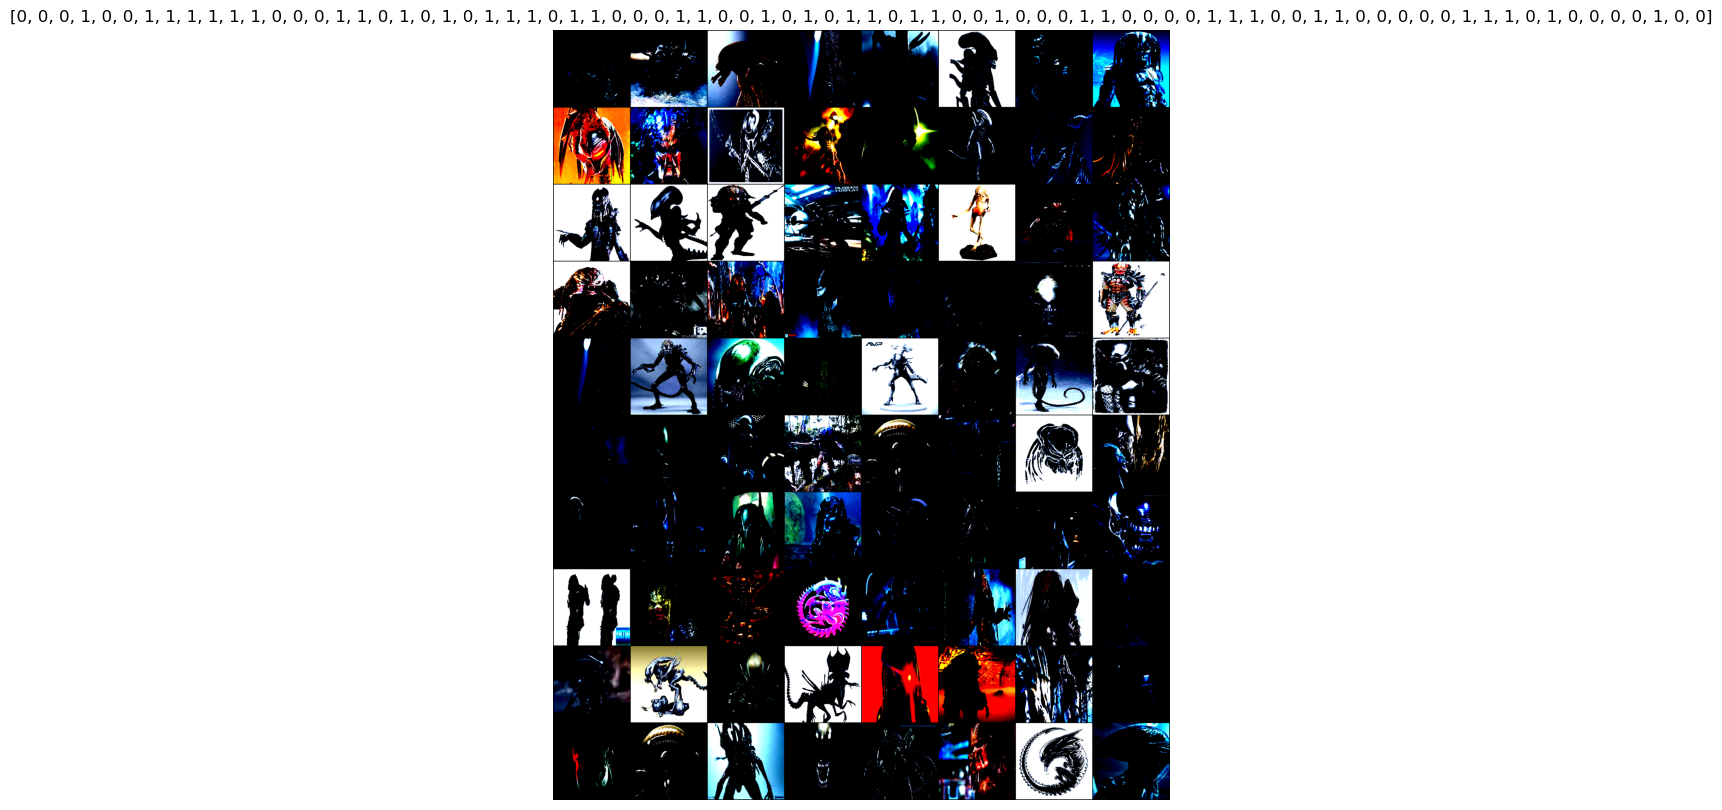

In [12]:
count = 1
for X in train_loader :
    
    grid = torchvision.utils.make_grid(X['image'], nrow=8)
    plt.figure(figsize=(10,10))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(X['label'].numpy().tolist());
    
    if count >= 1 :
       break
    count += 1

# Transfer learning

In [13]:
device = CONFIG['device']

# Define ResNet18 model with transfer learning
resnet = models.resnet18(pretrained=True)


for param in resnet.parameters():
     param.requires_grad = False   


num_ftrs = resnet.fc.in_features


resnet.fc = nn.Sequential(
               nn.Linear(num_ftrs, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)



resnet.to(device)



/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:

# Print the memory usage report
# Print the memory usage
print(torch.cuda.memory_allocated()/1e6)

45.024256


In [15]:
#the pre-trained ViT model
device = CONFIG['device']
vit  = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')


for param in vit.parameters():
    param.requires_grad = False   
  

num_features = vit.norm.normalized_shape[0]
# Replace the classifier head for fine-tuning

vit = nn.Sequential(vit,
               nn.Linear(num_features, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

vit.to(device)


Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dino_main


Sequential(
  (0): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNorm((3

In [16]:
# Print the memory usage
print(torch.cuda.memory_allocated()/1e6)

133.720576


In [17]:
import torch.optim as optim

learning_rate  = 1e-5
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet.parameters(), lr=learning_rate)
optimizer_vit  = optim.Adam(vit.parameters(), lr=learning_rate)

#lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)1

In [18]:
def save_model(path):
    torch.save({
                'epoch': 15,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                'train_loss': training_loss,
                }, path)

In [19]:


def train(model, optimizer) :

    training_loss = []
    training_Acc = []
    train_batch   = CONFIG['train_batch_size']


    for epoch in range( CONFIG['EPOCHS']):  

          gc.collect()
          model.train()
          train_epoch_loss = 0
          train_epoch_acc = 0

          bar = tqdm(enumerate(train_loader), total=len(train_loader))
          for step, batch in bar:
              images, labels = batch['image'], batch['label']
              images = images.to(device)
              labels= labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

            # forward + backward + optimize
              outputs = model(images)
              _,preds    = torch.max ( torch.softmax(outputs, dim = 1), 1)


              running_corrects = torch.sum(preds == labels)

              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()

              train_epoch_loss += loss.item()
              train_epoch_acc += running_corrects.item()/train_batch

              bar.set_description(f'loss: {loss.item()} acc: {running_corrects.item()/train_batch} batch_id: {step}')
              bar.set_postfix(Epoch=epoch, Train_Loss=train_epoch_loss/len(train_loader),Train_ACC=train_epoch_acc/len(train_loader),LR=optimizer.param_groups[0]['lr']) 


          #save_model(path)
          training_loss.append(train_epoch_loss/len(train_loader))
          training_Acc.append(train_epoch_acc/len(train_loader))
          gc.collect()
         
        
    return training_loss,training_Acc
        
        

training_loss_resnet,training_Acc_resnet = train(resnet, optimizer_resnet)


loss: 0.7078355550765991 acc: 0.4875 batch_id: 7: 100%|█| 8/8 [00:03<00:00,  2.34it/s, Epoch=0, LR=1e-5, Train_ACC=0.505, Train_Loss=0.
loss: 0.6627004742622375 acc: 0.6 batch_id: 7: 100%|█| 8/8 [00:01<00:00,  4.30it/s, Epoch=1, LR=1e-5, Train_ACC=0.52, Train_Loss=0.694]
loss: 0.6879143714904785 acc: 0.525 batch_id: 7: 100%|█| 8/8 [00:01<00:00,  4.29it/s, Epoch=2, LR=1e-5, Train_ACC=0.562, Train_Loss=0.6
loss: 0.6855001449584961 acc: 0.5625 batch_id: 7: 100%|█| 8/8 [00:01<00:00,  4.31it/s, Epoch=3, LR=1e-5, Train_ACC=0.6, Train_Loss=0.67
loss: 0.6643273830413818 acc: 0.6125 batch_id: 7: 100%|█| 8/8 [00:01<00:00,  4.31it/s, Epoch=4, LR=1e-5, Train_ACC=0.616, Train_Loss=0.
loss: 0.6430699825286865 acc: 0.7125 batch_id: 7: 100%|█| 8/8 [00:01<00:00,  4.34it/s, Epoch=5, LR=1e-5, Train_ACC=0.655, Train_Loss=0.
loss: 0.6462868452072144 acc: 0.725 batch_id: 7: 100%|█| 8/8 [00:01<00:00,  4.24it/s, Epoch=6, LR=1e-5, Train_ACC=0.673, Train_Loss=0.6
loss: 0.6460639238357544 acc: 0.7875 batch_id: 7

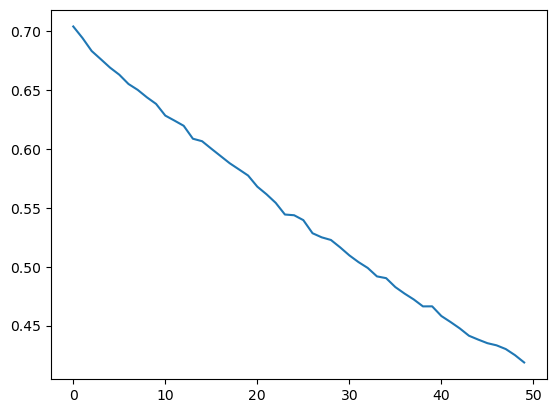

In [20]:
plt.plot(training_loss_resnet)

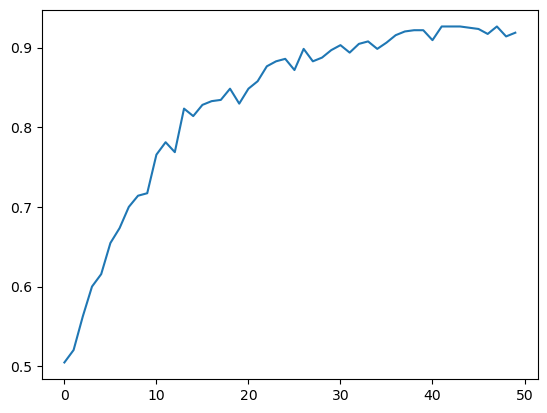

In [21]:
plt.plot(training_Acc_resnet)

In [22]:
training_loss_vit,training_Acc_vit = train(vit, optimizer_vit)


loss: 0.7543764710426331 acc: 0.55 batch_id: 7: 100%|█| 8/8 [00:03<00:00,  2.47it/s, Epoch=0, LR=1e-5, Train_ACC=0.503, Train_Loss=0.84
loss: 0.7533484697341919 acc: 0.575 batch_id: 7: 100%|█| 8/8 [00:03<00:00,  2.47it/s, Epoch=1, LR=1e-5, Train_ACC=0.545, Train_Loss=0.7
loss: 0.7381876707077026 acc: 0.625 batch_id: 7: 100%|█| 8/8 [00:03<00:00,  2.49it/s, Epoch=2, LR=1e-5, Train_ACC=0.562, Train_Loss=0.7
loss: 0.6883732676506042 acc: 0.65 batch_id: 7: 100%|█| 8/8 [00:03<00:00,  2.49it/s, Epoch=3, LR=1e-5, Train_ACC=0.598, Train_Loss=0.72
loss: 0.665029764175415 acc: 0.6 batch_id: 7: 100%|█| 8/8 [00:03<00:00,  2.46it/s, Epoch=4, LR=1e-5, Train_ACC=0.606, Train_Loss=0.693]
loss: 0.6586508750915527 acc: 0.6625 batch_id: 7: 100%|█| 8/8 [00:03<00:00,  2.50it/s, Epoch=5, LR=1e-5, Train_ACC=0.634, Train_Loss=0.
loss: 0.5774881839752197 acc: 0.7 batch_id: 7: 100%|█| 8/8 [00:03<00:00,  2.51it/s, Epoch=6, LR=1e-5, Train_ACC=0.653, Train_Loss=0.634
loss: 0.6110431551933289 acc: 0.65 batch_id: 7: 

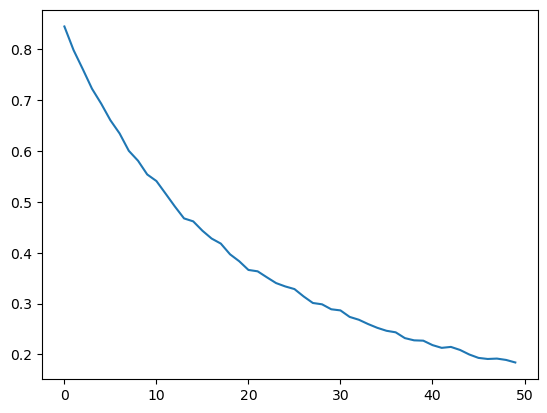

In [23]:
plt.plot(training_loss_vit)

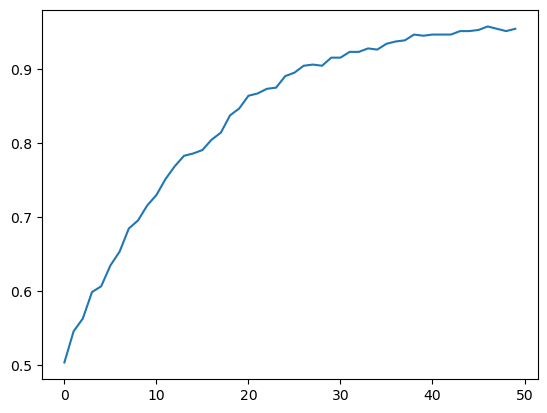

In [24]:
plt.plot(training_Acc_vit)

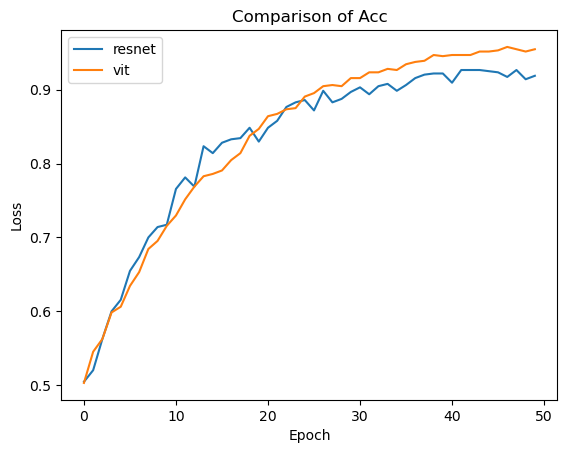

In [26]:
# Plot the data
plt.plot(training_Acc_resnet, label='resnet')
plt.plot(training_Acc_vit, label='vit')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Acc')
plt.legend()

# Show the plot
plt.show()

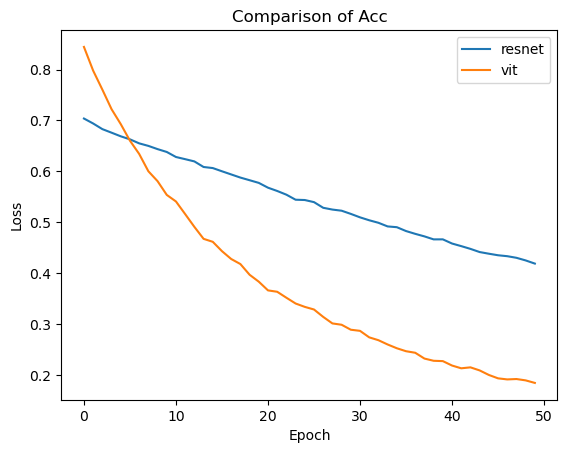

In [27]:
# Plot the data
plt.plot(training_loss_resnet, label='resnet')
plt.plot(training_loss_vit, label='vit')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Acc')
plt.legend()

# Show the plot
plt.show()